## Machine learning Model of Price Trend Prediction in Forex Market

In [1]:
import fxcmpy
import pandas as pd
import numpy as np
import datetime as dt

# Allows for printing the whole data frame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from pyti.accumulation_distribution import accumulation_distribution as ad
from pyti.aroon import aroon_up
from pyti.aroon import aroon_down
from pyti.average_true_range import average_true_range as atr
from pyti.chande_momentum_oscillator import chande_momentum_oscillator as cmo
from pyti.chaikin_money_flow import chaikin_money_flow as cmf 
from pyti.commodity_channel_index import commodity_channel_index as cci
from pyti.exponential_moving_average import exponential_moving_average as ema
from pyti.hull_moving_average import hull_moving_average as hma
from pyti.money_flow_index import money_flow_index as mfi
from pyti.on_balance_volume import on_balance_volume as obv
from pyti.simple_moving_average import simple_moving_average as sma
from pyti.stochastic import percent_k as percent_k
from pyti.stochastic import percent_d as percent_d
from pyti.smoothed_moving_average import smoothed_moving_average as smoothed_ma
from pyti.true_range import true_range as tr
from pyti.ultimate_oscillator import ultimate_oscillator as uo
from pyti.volatility import volatility as volat
from pyti.relative_strength_index import relative_strength_index as rsi
from pyti.williams_percent_r import williams_percent_r as wpr 

## Data Retrieval

GBP/JPY Price data from 2012 to 2018 is retrieved through FXCM's Restful API.

In [2]:
#set connection
con = fxcmpy.fxcmpy(config_file='fxcm.cfg')

#get candle data 2016-01-01 to 2018-06-19
df = con.get_candles('GBP/JPY', period='D1',start= dt.datetime(2012, 1, 1),end = dt.datetime(2018, 7, 23))

#check connection
con.is_connected()

True

## Feature Engineering

Gathering more data and feature engineering usually have the greatest payoff for improving model performance. In our model, we only gathered price data and generated features of technical indicators based on price. However, in more complexed models, trades data, economic indicators, sentiment data and cross market data, such as S&P 500, could all be incorporated. 

In [3]:
# Accumulation distribution
df['accum_dist'] = ad(df['askclose'], df['askhigh'], df['asklow'], df['tickqty'])

# Averagre true range
df['atr'] = atr(df['askclose'], 10)

# Chande momentum oscillator
df['cmo'] = cmo(df['askclose'], 10)

# chaikin_money_flow 
df['cmf'] = cmf(df['askclose'], df['askhigh'], df['asklow'], df['tickqty'], 10) 

# commodity channel index
df['cci'] = cci(df['askclose'], df['askhigh'], df['asklow'], 10)

# exponential moving average 
fast = 7
slow = 14
df['ema_fast'] = ema(df['askclose'], fast)
df['ema_slow'] = ema(df['askclose'], slow)

# hull moving average 
df['hma_fast'] = hma(df['askclose'], fast)
df['hma_slow'] = hma(df['askclose'], slow)

# money flow index
df['mfi'] = mfi(df['askclose'], df['askhigh'], df['asklow'], df['tickqty'], 10)

# on balance volume
df['obv'] = obv(df['askclose'], df['tickqty'])

# simple moving average
df['sma'] = sma(df['askclose'], period = 10)

# percent k
df['percent_k'] = percent_k(df['askclose'], period = 10)

# percent d
df['percent_d'] = percent_d(df['askclose'], period = 10)

# smoothed moving average
df['smoothed_ma'] = smoothed_ma(df['askclose'], period = 10)

# true range
df['true_range'] = tr(df['askclose'], period = 10)

# ultimate oscillator
df['ulti_osc'] = uo(df['askclose'], df['asklow'])

# volatility
df['volatility'] = volat(df['askclose'], period = 10)

# relative strength index
df['rsi'] = rsi(df['askclose'], period = 10)

# williams percent
df['williams'] = df['true_range'] = wpr(df['askclose']) 


In [54]:
##############################LOGIC PROBLEM: predict whether price close after 10 days > price close today? 

#define trend = whether up or down in ten days from now, if price(t) < price(t+10) , go up in 10 days, = 1, else = 0
df['trend'] = np.where(df['askclose'] < df['askclose'].shift(-10), 1, 0)

###df is our first version of data###

In [55]:
df.head(15)
#now df still has NA values, and random forest can't handle NA, so we need to remove them before running the model

,Unnamed: 0,date,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,accum_dist,atr,cmo,cmf,cci,ema_fast,ema_slow,hma_fast,hma_slow,mfi,obv,sma,percent_k,percent_d,smoothed_ma,true_range,ulti_osc,volatility,rsi,williams,trend
0,0,2012-01-02 22:00:00,119.526,119.242,119.527,118.955,119.618,119.318,119.622,119.025,12277,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,119.318000,-97.977436,NaN,NaN,NaN,-97.977436,0
1,1,2012-01-03 22:00:00,119.242,120.033,120.161,119.154,119.318,120.091,120.194,119.233,52708,41409.510926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52709.0,NaN,NaN,NaN,119.724842,-96.984143,NaN,NaN,NaN,-96.984143,0
2,2,2012-01-04 22:00:00,120.033,119.799,120.196,119.599,120.091,119.849,120.251,119.622,52090,26917.062595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,619.0,NaN,NaN,NaN,119.770657,-97.295109,NaN,NaN,NaN,-97.295109,0
3,3,2012-01-05 22:00:00,119.799,119.451,119.949,119.169,119.849,119.505,119.977,119.196,63691,13624.318677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-63072.0,NaN,NaN,NaN,119.693409,-97.737144,NaN,NaN,NaN,-97.737144,0
4,4,2012-01-06 22:00:00,119.451,118.714,119.734,118.540,119.505,118.780,119.763,118.566,53869,-20983.251080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-116941.0,NaN,NaN,NaN,119.470359,-98.668757,NaN,NaN,NaN,-98.668757,1
5,5,2012-01-09 22:00:00,118.714,118.702,118.866,118.254,118.780,118.903,118.903,118.289,48787,27803.748920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-68154.0,NaN,NaN,NaN,119.349273,-98.510704,NaN,NaN,NaN,-98.510704,1
6,6,2012-01-10 22:00:00,118.702,118.961,119.063,118.697,118.903,119.023,119.088,118.744,53127,60853.684966,NaN,NaN,NaN,NaN,119.179937,NaN,NaN,NaN,NaN,-15027.0,NaN,NaN,NaN,119.286733,-98.356506,NaN,NaN,NaN,-98.356506,1
7,7,2012-01-11 22:00:00,118.961,117.789,119.109,117.711,119.023,117.841,119.133,117.739,56479,12639.904478,NaN,NaN,NaN,NaN,118.788321,NaN,118.231548,NaN,NaN,-71506.0,NaN,NaN,NaN,119.032888,-99.875357,NaN,NaN,NaN,-99.875357,1
8,8,2012-01-12 22:00:00,117.789,117.662,118.108,117.512,117.841,117.750,118.131,117.535,62647,-4808.756595,NaN,NaN,NaN,NaN,118.438585,NaN,117.676476,NaN,NaN,-134153.0,NaN,NaN,NaN,118.823464,-99.992290,NaN,NaN,NaN,-99.992290,1
9,9,2012-01-13 22:00:00,117.662,117.809,118.186,117.275,117.750,118.006,118.211,117.295,68173,32850.127684,2.341000,-34.024896,0.062277,-4.300037,118.259462,NaN,117.513889,NaN,NaN,-65980.0,118.9066,0.109355,NaN,118.697955,-99.663334,NaN,1.211476,NaN,-99.663334,1


In [56]:
# Define Features to Train Model on 
features = list(df.loc[:,'askopen':'williams'])
features

['askopen',
 'askclose',
 'askhigh',
 'asklow',
 'tickqty',
 'accum_dist',
 'atr',
 'cmo',
 'cmf',
 'cci',
 'ema_fast',
 'ema_slow',
 'hma_fast',
 'hma_slow',
 'mfi',
 'obv',
 'sma',
 'percent_k',
 'percent_d',
 'smoothed_ma',
 'true_range',
 'ulti_osc',
 'volatility',
 'rsi',
 'williams']

In [57]:
#save to csv for convenience in future use
df.to_csv('MLmodel2.csv')

In [58]:
df = pd.read_csv('MLmodel2.csv')

In [59]:
df.shape

(1979, 33)

## Train and Test data Preparation

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, log_loss, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

In [61]:
#Split into training and testing data

train = df[(pd.to_datetime(df.date) < pd.to_datetime('2017-01-01')) 
           & (pd.to_datetime(df.date) >= pd.to_datetime('2012-01-01'))]

test = df[pd.to_datetime(df.date) >= pd.to_datetime('2017-01-01')]

X_train = train.loc[:,features]
y_train = train.loc[:,'trend']
X_test = test.loc[:,features]
y_test = test.loc[:,'trend']

In [62]:
#fill NA in y with 0
y_test = y_test.fillna(0)

In [63]:
#change float number to integer for classification purpose  
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [64]:
### Remove null values and replace with the median of each column ###
transform = Imputer(missing_values='NaN',strategy='median')

### Find median of each column in training set and replace null values ###
X_train_features = transform.fit_transform(X_train)

X_train = pd.DataFrame(X_train_features, index =X_train.index, columns = X_train.columns)

### Apply median from training set to null values of test set ###
X_test_features = transform.transform(X_test)

X_test = pd.DataFrame(X_test_features, index = X_test.index, columns = X_test.columns)

In [65]:
X_train.shape

(1498, 25)

In [66]:
X_test.shape

(481, 25)

## Logistic
The simplest example of logistic model used for machine learning

In [67]:
#step 1 import model you want to use
from sklearn.linear_model import LogisticRegression

In [68]:
#Step 2 Make an instance of the Model
logisticRegr = LogisticRegression()

In [69]:
# Step 3. Training the model on the data, storing the information learned from the data
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [70]:
# Step 4. Predict labels for new data
predictions = logisticRegr.predict(X_test)

In [71]:
# Use score method to get accuracy of model 
score = logisticRegr.score(X_test, y_test)
print(score)

0.5239085239085239


## Random Forest

Another commonly used machine learning model with hyperparameter tuning for price trend prediction

Hyperparameter tuning process is to optimize the random forest model by trying many different combinations evaluate the performance of each model using Scikit-Learn tools

In [72]:
# Train and fit classifier to Training Data
scores = {}
#Initialize parameter tracking
highest_score = 0
best_ne  = 0
best_md = 0
best_mln = 0
for ne in range(100, 600, 100):
    for md in range(3, 11):
        for mln in range(4, 100, 4):
            clf = RandomForestClassifier(n_estimators=ne, max_depth=md, max_leaf_nodes=mln, n_jobs=-1, verbose=0)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_pred.sum()
            metric = roc_auc_score(y_test, y_pred)
            
            #Set values for best parameters if new high auc_score
            if(metric > highest_score):
                highest_score = metric
                best_ne = ne
                best_md = md
                best_mln = mln
            
            scores[str(ne)+'_'+str(md)+'_'+str(mln)] = metric
            print(metric)

            ## binary classification 
            ## market data is really difficult to make these predictions, almost never get better than 75% accuracy. In Dr.Trevor Trinkino's prediction, he got accuracy around 50% as well.
            ## Curve: look at percetage of true positives and false negatives            
            ## another way is to look at correct proportion of prediction             
            ## there are other ways to search for hyperparameter more efficiently using a genetic algorithm or other similar techniques 


0.5174759132182714
0.4930598877105427
0.5034137381298953
0.493458445969363
0.5031884660705621
0.49107576072641573
0.5047740347958688
0.5204910930893463
0.5164968461911693
0.4996274346711028
0.5018021764746656
0.4952432938240799
0.5009963956470506
0.49941082692174393
0.4950440146946697
0.49941949123171836
0.501005059957025
0.4950440146946697
0.4998093851805642
0.49702814167879666
0.5055711513135094
0.49901226866292364
0.487506065016982
0.49544257295349
0.49048658764815967
0.4903133014486727
0.4928606085811326
0.514893948845914
0.5097386844111735
0.5135076592500173
0.49762597906702716
0.49762597906702716
0.5067668260899701
0.4948533998752339
0.49742669993761696
0.49187287724405626
0.49643896860054065
0.5079538365564568
0.5115235322658903
0.48909163374228876
0.49901226866292364
0.4950440146946697
0.5009963956470506
0.49187287724405626
0.504973313925279
0.4922627711929021
0.4950440146946697
0.49881298953351355
0.4847941359950094
0.49941082692174393
0.49901226866292364
0.49365772509877315
0

0.49961010605115413
0.4986223747140778
0.4980245373258474
0.4950440146946697
0.49544257295349
0.4932591668399529
0.4960404103417204
0.514893948845914
0.5025906286823317
0.49782525819643725
0.4966382477299508
0.5061603243917654
0.5133083801206072
0.5021920704235114
0.49782525819643725
0.4980245373258474
0.49147431898523597
0.5196593193318084
0.508941567893533
0.5135076592500173
0.49365772509877315
0.5065588826505858
0.5015942330352812
0.4952432938240799
0.49961010605115413
0.509140847022943
0.4998093851805642
0.5184723088653219
0.49544257295349
0.493458445969363
0.5093401261523532
0.5071567200388161
0.5000086643099745
0.49722742080820687
0.5105271366188397
0.517077354959451
0.49782525819643725
0.5009963956470506
0.5013949539058709
0.49921154779233384
0.49762597906702716
0.5015942330352812
0.5144953905870937
0.5129098218617869
0.5083437305053025
0.4952432938240799
0.5053632078741249
0.5129098218617869
0.49941082692174393
0.5168780758300409
0.51112497400707
0.4930598877105427
0.4950440146

0.5061603243917654
0.5109256948776599
0.49722742080820687
0.49782525819643725
0.5013949539058709
0.49365772509877315
0.4932591668399529
0.49544257295349
0.4956418520829002
0.5002079434393845
0.5133083801206072
0.5043754765370485
0.493458445969363
0.5041761974076385
0.5103278574894295
0.5192607610729882
0.519061481943578
0.5081444513758924
0.5101285783600195
0.5057617661329451
0.5017935121646911
0.49722742080820687
0.503578360019408
0.5150932279753241
0.5105271366188397
0.5057617661329451
0.5081444513758924
0.5123119844735565
0.5015942330352812
0.49941082692174393
0.49702814167879666
0.5013949539058709
0.493458445969363
0.4896894711305192
0.4930598877105427
0.5085430096347128
0.49147431898523597
0.5063596035211755
0.5192607610729882
0.5083437305053025
0.503578360019408
0.505562487003535
0.5144953905870937
0.5232290150412421
0.5208463297982949
0.5256117002841894
0.5097300201011992
0.5121127053441464
0.5186629236847577
0.49921154779233384
0.5121127053441464
0.5234282941706522
0.5142961114

In [73]:
#Show the best parameters 
print ("highest_score:" , highest_score, " best_ne:", best_ne, "best_md:", best_md, " best_mln:", best_mln)

highest_score: 0.5434775074513065  best_ne: 100 best_md: 9  best_mln: 88


In [24]:

# A close look at feature importances for our previous feature engineering 
clf.feature_importances_

array([0.02878071, 0.03723854, 0.03052342, 0.03403627, 0.02363364,
       0.10791286, 0.05590091, 0.02824141, 0.0350311 , 0.02863285,
       0.04526127, 0.04199755, 0.03869652, 0.03557814, 0.02898595,
       0.07621131, 0.04708613, 0.01454325, 0.02482596, 0.05394833,
       0.03532233, 0.03637833, 0.03609886, 0.03981298, 0.03532139])

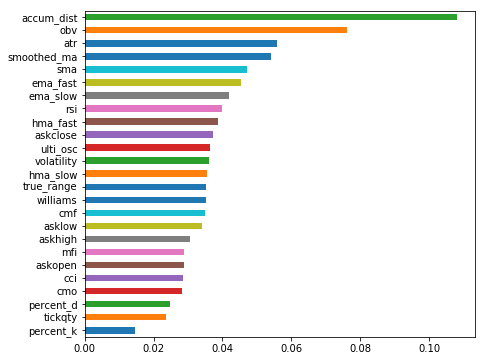

In [31]:
#Plot of feature importances 
feature_importances = pd.Series(clf.feature_importances_, index = X_train.columns)
fi = feature_importances.sort_values()
fi.plot(kind = "barh", figsize = (7,6))

## Backtesting the model based on profits 

In [75]:
#entry signal when y_pred = 1, exit when it's day 10. 
X_test['prediction'] = y_pred

In [82]:
X_test

,askopen,askclose,askhigh,asklow,tickqty,accum_dist,atr,cmo,cmf,cci,ema_fast,ema_slow,hma_fast,hma_slow,mfi,obv,sma,percent_k,percent_d,smoothed_ma,true_range,ulti_osc,volatility,rsi,williams,prediction
1498,144.608,144.163,145.416,143.546,414304.0,3.514195e+07,3.752695,-18.986412,0.017598,-0.388107,144.002215,144.594521,144.113520,143.258060,27.083314,-2832775.0,144.4364,0.410376,0.256392,144.247743,-66.052016,21.966390,1.176717,49.338185,-66.052016,0
1499,144.163,144.599,144.978,143.704,443042.0,3.532139e+07,3.656925,-23.006834,0.128833,0.340156,144.158305,144.543068,144.625964,143.538176,35.700042,-2389733.0,144.3766,0.566369,0.445182,144.282869,-65.491763,25.758145,1.233832,52.568287,-65.491763,0
1500,144.599,143.391,144.681,142.517,619096.0,3.520238e+07,3.518733,-31.900604,0.067834,-2.358444,143.931471,144.317848,144.197020,143.638460,35.206503,-3008829.0,144.1346,0.164835,0.380526,144.193682,-67.044024,28.203251,1.456892,43.943173,-67.044024,0
1501,143.391,143.858,144.075,143.003,435680.0,3.546168e+07,3.326059,-10.122478,0.156390,-1.212800,143.901319,144.184800,143.774619,143.718011,49.545175,-2573149.0,143.9913,0.528894,0.420033,144.160114,-66.443936,31.933438,1.801190,47.633795,-66.443936,0
1502,143.858,143.376,143.540,143.353,429.0,3.546135e+07,3.152653,-15.623943,0.247079,-1.553354,143.769296,143.992212,143.412861,143.691548,48.632564,-2573578.0,143.8869,0.226131,0.306620,144.081703,-67.063298,32.100151,1.773960,44.289823,-67.063298,0
1503,143.376,141.196,143.879,141.072,450408.0,3.505074e+07,3.178588,-37.295803,0.086368,-6.191428,143.055881,143.536215,142.142198,143.217957,52.958316,-3023986.0,143.5765,0.000000,0.251675,143.793132,-69.864563,27.625766,1.001853,32.739651,-69.864563,0
1504,141.196,141.026,141.470,140.194,498645.0,3.520236e+07,3.218929,-32.182658,0.084711,-9.527822,142.410462,143.102055,140.821655,142.448898,50.444812,-3522631.0,143.2627,0.000000,0.075377,143.516419,-70.083010,21.733184,0.797750,32.016208,-70.083010,0
1505,141.026,140.943,141.497,139.973,692708.0,3.539145e+07,3.263536,-29.350135,0.158254,-8.738097,141.919589,142.723800,140.183381,141.640140,47.064999,-4215339.0,143.0176,0.000000,0.000000,143.259077,-70.189664,21.239152,0.689975,31.636970,-70.189664,0
1506,140.943,139.557,141.060,138.938,566580.0,3.515542e+07,3.442283,-73.661951,0.078096,-11.315365,141.134766,142.200473,139.567381,140.736456,42.936188,-4781919.0,142.6717,0.000000,0.000000,142.888869,-71.970651,18.535249,0.550628,25.936658,-71.970651,0
1507,139.557,139.794,140.597,139.187,458398.0,3.509170e+07,3.602254,-65.709129,-0.041745,-9.643459,140.661048,141.785945,139.199556,139.956574,45.582841,-4323521.0,142.1903,0.047005,0.015668,142.579382,-71.666110,16.190947,0.531172,28.388154,-71.666110,0


Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\Users\xyang\FXCMAPI\anaconda3\lib\site-packages\socketIO_client\transports.py", line 146, in recv_packet
    packet_text = self._connection.recv()
  File "C:\Users\xyang\FXCMAPI\anaconda3\lib\site-packages\websocket\_core.py", line 300, in recv
    opcode, data = self.recv_data()
  File "C:\Users\xyang\FXCMAPI\anaconda3\lib\site-packages\websocket\_core.py", line 317, in recv_data
    opcode, frame = self.recv_data_frame(control_frame)
  File "C:\Users\xyang\FXCMAPI\anaconda3\lib\site-packages\websocket\_core.py", line 330, in recv_data_frame
    frame = self.recv_frame()
  File "C:\Users\xyang\FXCMAPI\anaconda3\lib\site-packages\websocket\_core.py", line 364, in recv_frame
    return self.frame_buffer.recv_frame()
  File "C:\Users\xyang\FXCMAPI\anaconda3\lib\site-packages\websocket\_abnf.py", line 361, in recv_frame
    self.recv_header()
  File "C:\Users\xyang\FXCMAPI\anaconda3\lib\site-packages\websocket\_ab

In [81]:
#define pip cost and lot size
pip_cost = .0911
lot_size = 10

#set up beginning point 
begin_prices = []
end_prices = []
profits = 0

#Finding when a position is initiated and getting the open/close prices for the position
for i, row in X_test.iterrows():
    if row['prediction'] == 1:
        begin_prices.append(float(row['askclose']))
        row['askclose'] = row['askclose'].shit(-10)
        end_prices.append(float(row['askclose'])



SyntaxError: unexpected EOF while parsing (<ipython-input-81-f20dca58455b>, line 15)

In [33]:
#Calculating profit/loss using pre-defined pip cost and lot size
for i in range(len(begin_prices)):
    profit = (end_prices[i] - begin_prices[i]) * 100 * pip_cost * lot_size
    profits += profit
    print("The return for trade " + str(i + 1) + " is:" + str(int(profit)))

print("The total return during this period is:" + str(int(profits)))

,askopen,askclose,askhigh,asklow,tickqty,accum_dist,atr,cmo,cmf,cci,ema_fast,ema_slow,hma_fast,hma_slow,mfi,obv,sma,percent_k,percent_d,smoothed_ma,true_range,ulti_osc,volatility,rsi,williams,prediction
1498,144.608,144.163,145.416,143.546,414304.0,3.514195e+07,3.752695,-18.986412,0.017598,-0.388107,144.002215,144.594521,144.113520,143.258060,27.083314,-2832775.0,144.4364,0.410376,0.256392,144.247743,-66.052016,21.966390,1.176717,49.338185,-66.052016,0
1499,144.163,144.599,144.978,143.704,443042.0,3.532139e+07,3.656925,-23.006834,0.128833,0.340156,144.158305,144.543068,144.625964,143.538176,35.700042,-2389733.0,144.3766,0.566369,0.445182,144.282869,-65.491763,25.758145,1.233832,52.568287,-65.491763,0
1500,144.599,143.391,144.681,142.517,619096.0,3.520238e+07,3.518733,-31.900604,0.067834,-2.358444,143.931471,144.317848,144.197020,143.638460,35.206503,-3008829.0,144.1346,0.164835,0.380526,144.193682,-67.044024,28.203251,1.456892,43.943173,-67.044024,0
1501,143.391,143.858,144.075,143.003,435680.0,3.546168e+07,3.326059,-10.122478,0.156390,-1.212800,143.901319,144.184800,143.774619,143.718011,49.545175,-2573149.0,143.9913,0.528894,0.420033,144.160114,-66.443936,31.933438,1.801190,47.633795,-66.443936,0
1502,143.858,143.376,143.540,143.353,429.0,3.546135e+07,3.152653,-15.623943,0.247079,-1.553354,143.769296,143.992212,143.412861,143.691548,48.632564,-2573578.0,143.8869,0.226131,0.306620,144.081703,-67.063298,32.100151,1.773960,44.289823,-67.063298,0
1503,143.376,141.196,143.879,141.072,450408.0,3.505074e+07,3.178588,-37.295803,0.086368,-6.191428,143.055881,143.536215,142.142198,143.217957,52.958316,-3023986.0,143.5765,0.000000,0.251675,143.793132,-69.864563,27.625766,1.001853,32.739651,-69.864563,0
1504,141.196,141.026,141.470,140.194,498645.0,3.520236e+07,3.218929,-32.182658,0.084711,-9.527822,142.410462,143.102055,140.821655,142.448898,50.444812,-3522631.0,143.2627,0.000000,0.075377,143.516419,-70.083010,21.733184,0.797750,32.016208,-70.083010,0
1505,141.026,140.943,141.497,139.973,692708.0,3.539145e+07,3.263536,-29.350135,0.158254,-8.738097,141.919589,142.723800,140.183381,141.640140,47.064999,-4215339.0,143.0176,0.000000,0.000000,143.259077,-70.189664,21.239152,0.689975,31.636970,-70.189664,0
1506,140.943,139.557,141.060,138.938,566580.0,3.515542e+07,3.442283,-73.661951,0.078096,-11.315365,141.134766,142.200473,139.567381,140.736456,42.936188,-4781919.0,142.6717,0.000000,0.000000,142.888869,-71.970651,18.535249,0.550628,25.936658,-71.970651,0
1507,139.557,139.794,140.597,139.187,458398.0,3.509170e+07,3.602254,-65.709129,-0.041745,-9.643459,140.661048,141.785945,139.199556,139.956574,45.582841,-4323521.0,142.1903,0.047005,0.015668,142.579382,-71.666110,16.190947,0.531172,28.388154,-71.666110,0


In [30]:
pd.merge(X_test, y_pred, left_on = None, right_on = None, left_index=False, right_index=False)

ValueError: can not merge DataFrame with instance of type <class 'numpy.ndarray'>

In [ ]:
pd.concat([X_test, y_pred])